# Time Series Forecasting with XGBoost - Use python and machine learning to predict energy consumption
Time Series Forecasting with XGBoost - Use python and machine learning to predict energy consumption <br>
https://www.youtube.com/watch?v=vV12dGe_Fho

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

c:\Users\Jansen-Lin\anaconda3\envs\Data_Science_2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Types of Time Series Data

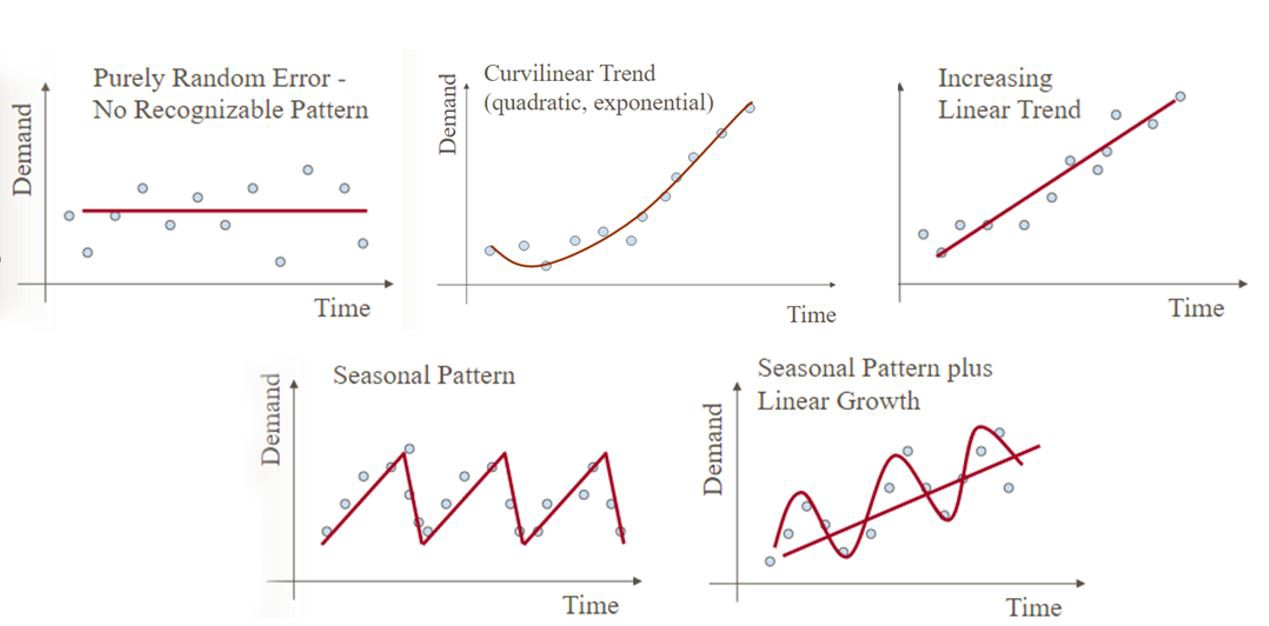

In [2]:
df = pd.read_csv("../src/hec/PJME_hourly.csv")
df = df.set_index('Datetime')
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2+ MB


[]

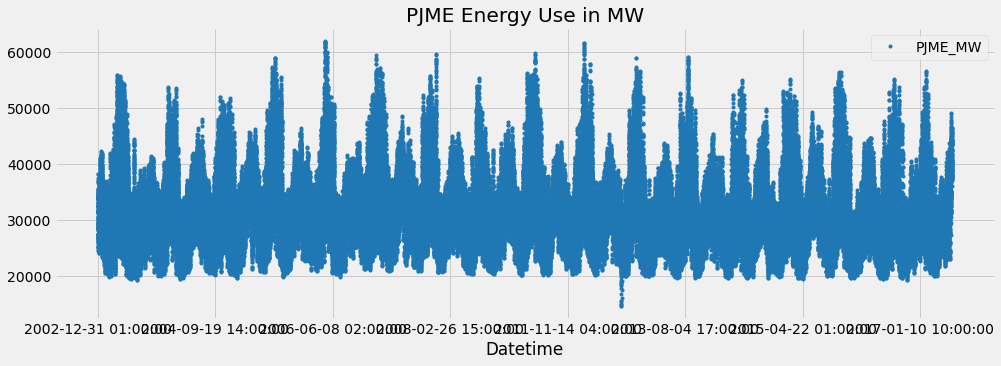

In [4]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title="PJME Energy Use in MW")
plt.plot()

In [5]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

[]

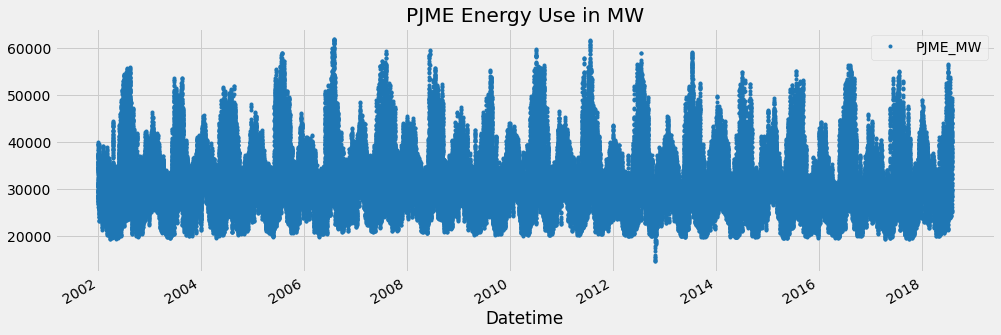

In [8]:
df.plot(style='.', 
        figsize=(15, 5),
        color=color_pal[0],
        title="PJME Energy Use in MW")
plt.plot()


## Train / Test Split

In [9]:
train = df.loc[df.index < "2015-01-01"]
test = df.loc[df.index >= '2015-01-01']

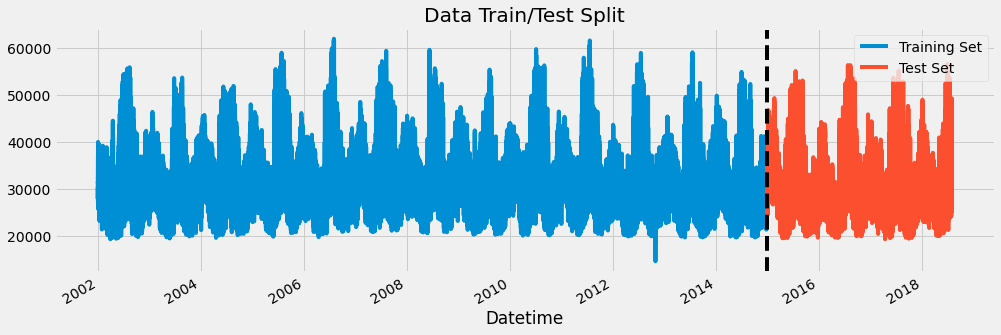

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = "Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline("2015-01-01",color='black', ls="--")
ax.legend(['Training Set', "Test Set"]) # these are the actual legends that are displayed.
plt.show()

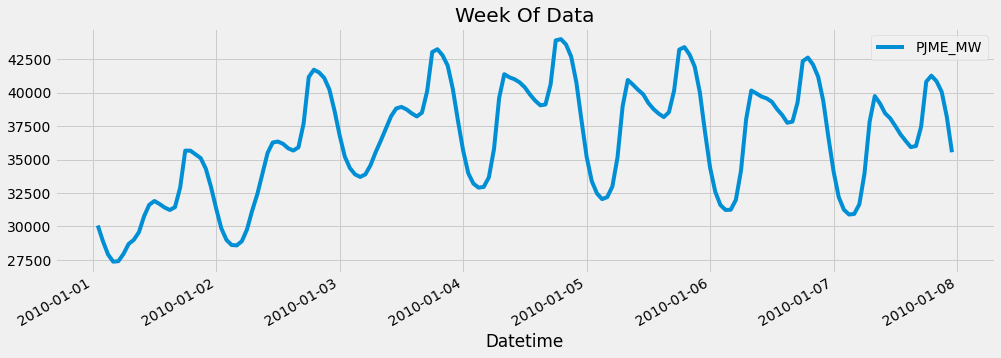

In [11]:
df.loc[(df.index > "2010-01-01") & (df.index < "2010-01-08")] \
    .plot(figsize=(15,5), title="Week Of Data")
plt.show()

## Feature Creation

In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [13]:
df = create_features(df)

## Visualize our Feature/Target Relationship

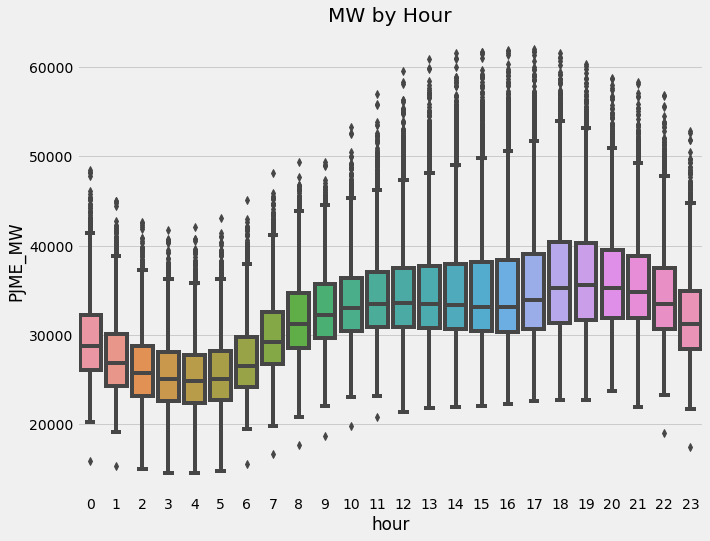

In [14]:
fig ,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y="PJME_MW")
ax.set_title("MW by Hour")
plt.show()

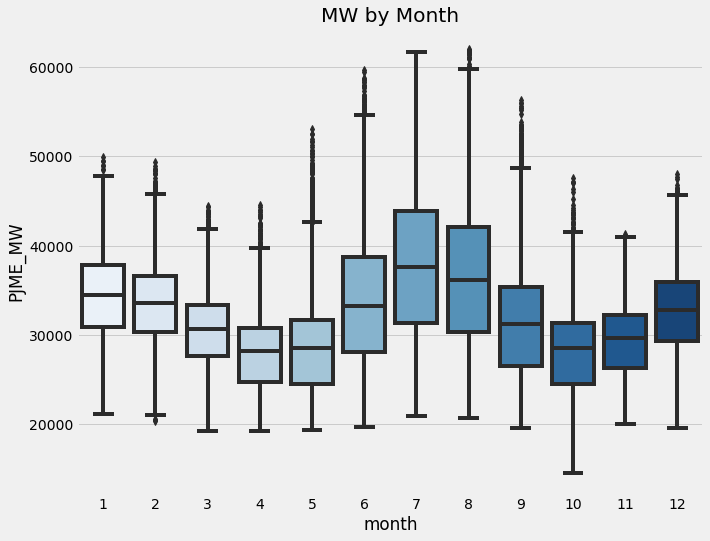

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y="PJME_MW", palette="Blues")
ax.set_title("MW by Month")
plt.show()


## Create our Model

In [16]:
train = create_features(train)
test = create_features(test)

In [17]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[09:17:41] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[09:17:41] WARNING: ..\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32605.14062	validation_1-rmse:31657.16016


c:\Users\Jansen-Lin\anaconda3\envs\Data_Science_2\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12581.21777	validation_1-rmse:11743.75098
[200]	validation_0-rmse:5835.12353	validation_1-rmse:5365.67676
[300]	validation_0-rmse:3915.75513	validation_1-rmse:4020.67017
[400]	validation_0-rmse:3443.16431	validation_1-rmse:3853.40405
[500]	validation_0-rmse:3285.33740	validation_1-rmse:3805.30200
[600]	validation_0-rmse:3201.92969	validation_1-rmse:3772.44922
[700]	validation_0-rmse:3148.14209	validation_1-rmse:3750.91064
[800]	validation_0-rmse:3109.24194	validation_1-rmse:3733.89648
[900]	validation_0-rmse:3079.39966	validation_1-rmse:3725.61206
[999]	validation_0-rmse:3052.73462	validation_1-rmse:3722.92261


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=20,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Feature Importance

In [19]:
reg.feature_importances_

array([0.11356898, 0.28172174, 0.15294196, 0.05881389, 0.36996272,
       0.02299066], dtype=float32)

In [26]:
reg.feature_names_in_

AttributeError: 'XGBRegressor' object has no attribute 'feature_names_in_'

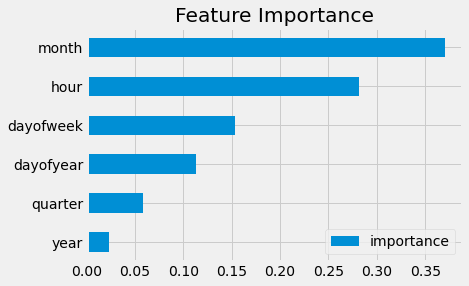

In [27]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=FEATURES,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [28]:
test['prediction'] = reg.predict(X_test)

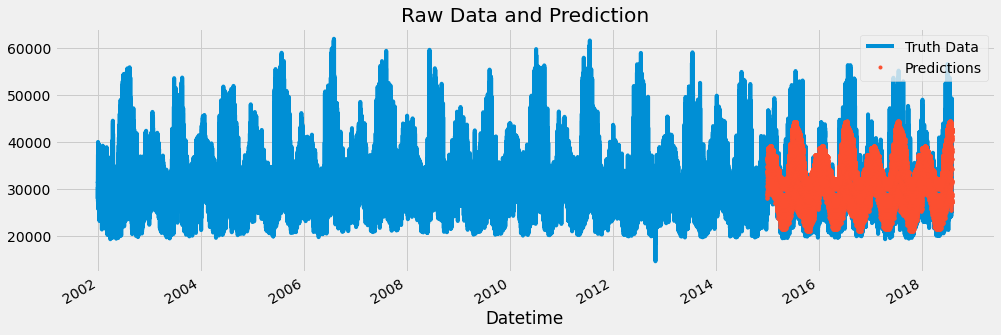

In [32]:
df = df.merge(test[['prediction']], how='left',
              left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

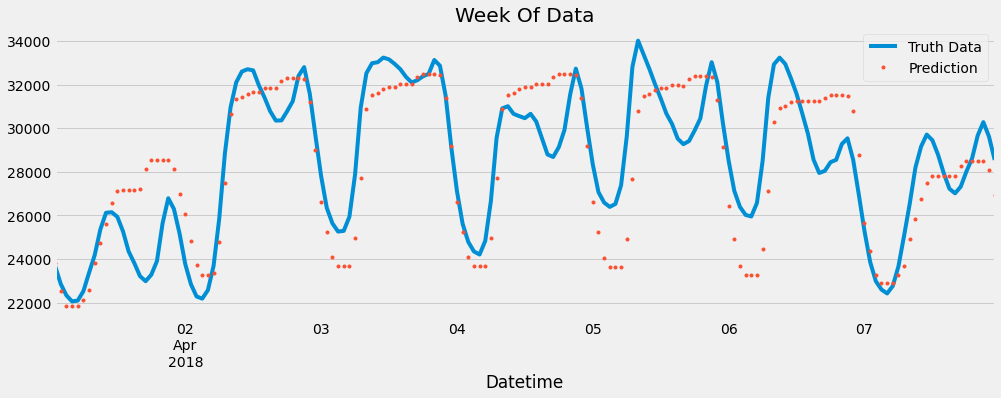

In [34]:
ax = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()


## Score (RMSE)

In [35]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 3722.92


## Calculate Error

In [36]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12853.568034
2016-08-14    12796.636312
2016-09-10    11369.115967
2015-02-20    10931.238200
2016-09-09    10877.764323
2018-01-06    10475.434652
2016-08-12    10138.022217
2015-02-21     9847.064535
2015-02-16     9753.021729
2018-01-07     9710.187744
Name: error, dtype: float64

## Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)